## Import Data Into Project ##

In [24]:
# Import libraries
import os
import random
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
# paths for data

train_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train"
test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"



In [12]:
# funcs to import images

def process_image_batches(img_paths, processed_images):
    """ Import images from the specified directory """
    
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=2)
        img = img / 255.0
        processed_images.append(img)

def import_and_process_images(img_dir, batch_size = int):
    """ Import images from the specified directory """
    start = time.time()
    processed_images = []
    img_paths = []

    for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.endswith(".JPEG"):
                     img_paths.append(os.path.join(root, file))

                     if len(img_paths) == batch_size:
                          random.shuffle(img_paths)
                          process_image_batches(img_paths, processed_images)
                          break
                          
    end = time.time()
    print(f"The function took {round(end - start)} seconds to run.")
    return processed_images


In [15]:
# import images

train_images = import_and_process_images(train_dir, batch_size = 20000)
test_images = import_and_process_images(test_dir, batch_size = 5000)
val_images = import_and_process_images(val_dir, batch_size = 5000)


The function took 142 seconds to run.
The function took 35 seconds to run.
The function took 36 seconds to run.


## Inspect images ##

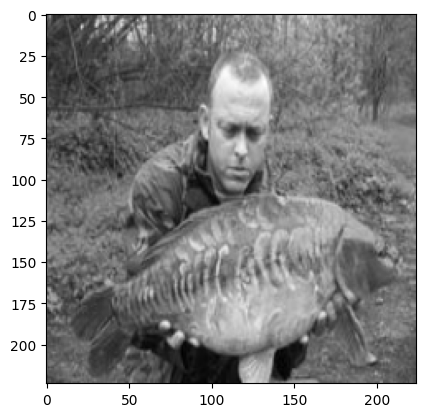

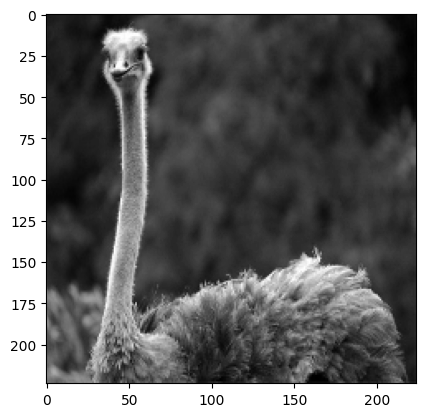

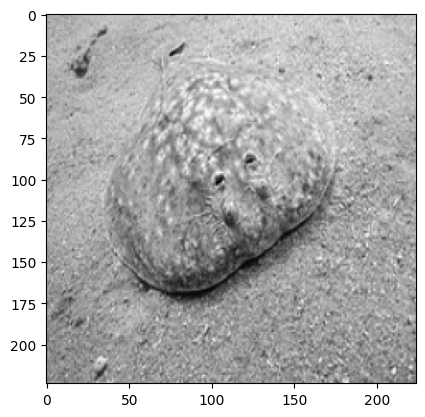

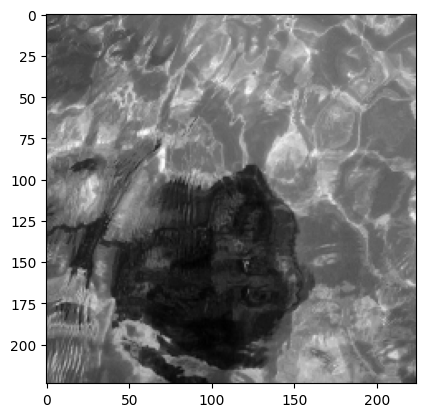

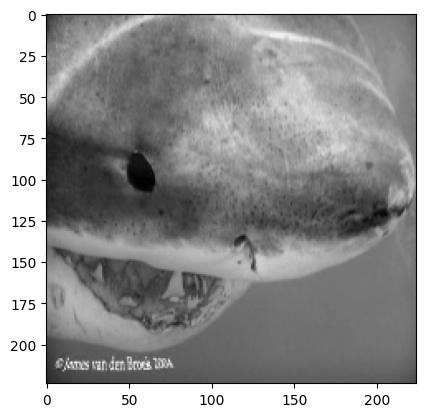

In [26]:
# view images
for i in range(0, 5):
    plt.imshow(train_images[i], cmap='gray')
    plt.show()